In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

In [3]:
# From Covid Tracking API
# https://covidtracking.com/api/
api_us = 'https://covidtracking.com/api/us/daily'
api_states = 'https://covidtracking.com/api/states/daily'

# https://github.com/COVID19Tracking/associated-data
f_pop = 'associated-data/us_census_data/us_census_2018_population_estimates_states.csv'

In [4]:
df_us = pd.read_json(api_us)
df_states = pd.read_json(api_states)
df_pop = pd.read_csv(f_pop)

In [5]:
df_us.shape

(25, 17)

In [6]:
df_states.shape

(1261, 17)

In [7]:
df_pop.head()

,state,state_name,geo_id,population,pop_density
0,AL,Alabama,1,4887871,96.509389
1,AK,Alaska,2,737438,1.291523
2,AZ,Arizona,4,7171646,63.135855
3,AR,Arkansas,5,3013825,57.919684
4,CA,California,6,39557045,253.906502


In [8]:
df_us['date'] = df_us['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df_states['date'] = df_states['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [9]:
df_us.sort_values(by=['date']).tail()

,date,states,positive,negative,posNeg,pending,hospitalized,death,total,hash,dateChecked,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
4,2020-03-24,56,51954,292758,344712,14433,4468.0,675.0,359145,eaedae24caa3d2c2dcbad823b248b729972e9960,2020-03-24T20:00:00Z,344712,204.0,1143.0,55437.0,9802.0,65239.0
3,2020-03-25,56,63928,357604,421532,51235,6136.0,900.0,472767,99e1bdff6a809d12b2e76a9e7c8a678d32a6f670,2020-03-25T20:00:00Z,421532,225.0,1668.0,64846.0,11974.0,76820.0
2,2020-03-26,56,80735,438603,519338,60251,10131.0,1163.0,579589,77e73bd9ca5316e76685e4fd31fd7adbd7ba4f45,2020-03-26T20:00:00Z,519338,263.0,3995.0,80999.0,16807.0,97806.0
1,2020-03-27,56,99413,527220,626633,60094,13718.0,1530.0,686727,5e9611f927d035074ac65594ad30669ef8299d75,2020-03-27T20:00:00Z,626633,367.0,3587.0,88617.0,18678.0,107295.0
0,2020-03-28,56,118234,617470,735704,65712,16729.0,1965.0,801416,a54933aec2de2cb0f418ffbc85c6c58d7481be77,2020-03-28T20:00:00Z,735704,435.0,3011.0,90250.0,18821.0,109071.0


In [10]:
df_states.sort_values(by=['date']).tail()

,date,state,positive,negative,pending,hospitalized,death,total,hash,dateChecked,totalTestResults,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
32,2020-03-28,NE,96.0,1904.0,NaN,NaN,2.0,2000,936157c283223d112cd1aa18d45b543d188ae577,2020-03-28T20:00:00Z,2000,31,2.0,0.0,143.0,11.0,154.0
31,2020-03-28,ND,83.0,2809.0,NaN,16.0,1.0,2892,327f76bbe39ccd8cf1b2cbf9ee1747bd419cb70a,2020-03-28T20:00:00Z,2892,38,1.0,3.0,382.0,18.0,400.0
30,2020-03-28,NC,935.0,16592.0,NaN,87.0,4.0,17527,6c1a0bb65d1d7ec7c17e54522c0b6ba7fddac5d6,2020-03-28T20:00:00Z,17527,37,1.0,10.0,2219.0,172.0,2391.0
28,2020-03-28,MS,663.0,2560.0,NaN,219.0,13.0,3223,37be39d177f27107e3b3a5a0663681b8df69325b,2020-03-28T20:00:00Z,3223,28,5.0,34.0,0.0,84.0,84.0
0,2020-03-28,AK,85.0,2836.0,NaN,5.0,2.0,2921,edb7e6bcde715f8bbea31547e99aa8b4712ea5fb,2020-03-28T20:00:00Z,2921,2,1.0,2.0,517.0,16.0,533.0


In [11]:
# Merge in population data
df_states = pd.merge(df_states, df_pop, on='state')

# Calculate positive as percent of population
df_states['pos_by_pop'] = df_states['positive'] / df_states['population']

# Calculate total tests
df_states['total'] = df_states['positive'] + df_states['negative']

# Calculate percent of tests that are positive
df_states['positive_rate'] = df_states['positive'] / df_states['total']

# Calculate percent of population tested
df_states['test_rate'] = df_states['total'] / df_states['population']

In [12]:
df_states.tail()

,date,state,positive,negative,pending,hospitalized,death,total,hash,dateChecked,...,negativeIncrease,positiveIncrease,totalTestResultsIncrease,state_name,geo_id,population,pop_density,pos_by_pop,positive_rate,test_rate
1204,2020-03-11,WY,0.0,NaN,NaN,NaN,NaN,NaN,18fc4cee9e62382b649645f5fb862fd1598ad7c2,2020-03-11T20:00:00Z,...,0.0,0.0,0.0,Wyoming,56,577737,5.950611,0.0,NaN,NaN
1205,2020-03-10,WY,0.0,0.0,0.0,NaN,NaN,0.0,ac695ca11cd43d13514370bf495bb3af78f1b66f,2020-03-10T20:00:00Z,...,0.0,0.0,0.0,Wyoming,56,577737,5.950611,0.0,NaN,0.0
1206,2020-03-09,WY,0.0,NaN,NaN,NaN,NaN,NaN,1306b115d298a86cb3e626a0d975e35767198712,2020-03-09T20:00:00Z,...,0.0,0.0,0.0,Wyoming,56,577737,5.950611,0.0,NaN,NaN
1207,2020-03-08,WY,0.0,NaN,NaN,NaN,NaN,NaN,3c360a7f81ed305bc73fb5dfbc07aec951489c2f,2020-03-08T20:00:00Z,...,0.0,0.0,0.0,Wyoming,56,577737,5.950611,0.0,NaN,NaN
1208,2020-03-07,WY,0.0,NaN,NaN,NaN,NaN,NaN,d311061ed771387fdb2db7b876bf2f72435f0de7,2020-03-07T21:00:00Z,...,NaN,NaN,NaN,Wyoming,56,577737,5.950611,0.0,NaN,NaN


In [13]:
df_states.describe()

,positive,negative,pending,hospitalized,death,total,totalTestResults,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,geo_id,population,pop_density,pos_by_pop,positive_rate,test_rate
count,1209.000000,1104.000000,406.000000,188.000000,545.000000,1104.000000,1209.000000,1209.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1209.000000,1.209000e+03,1196.000000,1209.000000,1099.000000,1104.000000
mean,471.297767,2950.432065,722.078818,313.680851,15.100917,3465.220109,3165.488834,29.457403,1.698358,14.503889,532.452031,102.006914,634.458081,29.457403,6.578231e+06,430.920835,0.000053,0.126401,0.000598
std,2732.648772,7992.613532,5709.804952,1152.624536,49.181713,10554.303106,10131.948863,16.233296,9.448903,130.054584,1474.085192,515.126151,1845.651006,16.233296,7.400317e+06,1604.580207,0.000160,0.150628,0.001001
min,0.000000,0.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-1.000000,-44.000000,-1.000000,-6.000000,1.000000,5.777370e+05,1.291523,0.000000,0.000000,0.000000
25%,5.000000,80.000000,4.000000,13.000000,1.000000,94.000000,55.000000,16.000000,0.000000,0.000000,0.000000,1.000000,9.000000,16.000000,1.805832e+06,54.955978,0.000001,0.038982,0.000022
50%,36.000000,361.000000,21.000000,50.500000,3.000000,468.000000,337.000000,29.000000,0.000000,0.000000,34.000000,9.000000,61.000000,29.000000,4.468402e+06,109.860468,0.000010,0.083333,0.000128
75%,187.000000,2294.000000,91.000000,145.750000,10.000000,2508.250000,2271.000000,42.000000,1.000000,0.000000,366.000000,43.000000,426.000000,42.000000,7.535591e+06,229.511156,0.000049,0.150851,0.000769
max,52318.000000,103616.000000,64400.000000,10054.000000,728.000000,155934.000000,155934.000000,72.000000,209.000000,3039.000000,16272.000000,7683.000000,23649.000000,72.000000,3.955704e+07,11490.119540,0.002677,0.891705,0.007979


# United States Positive Cases

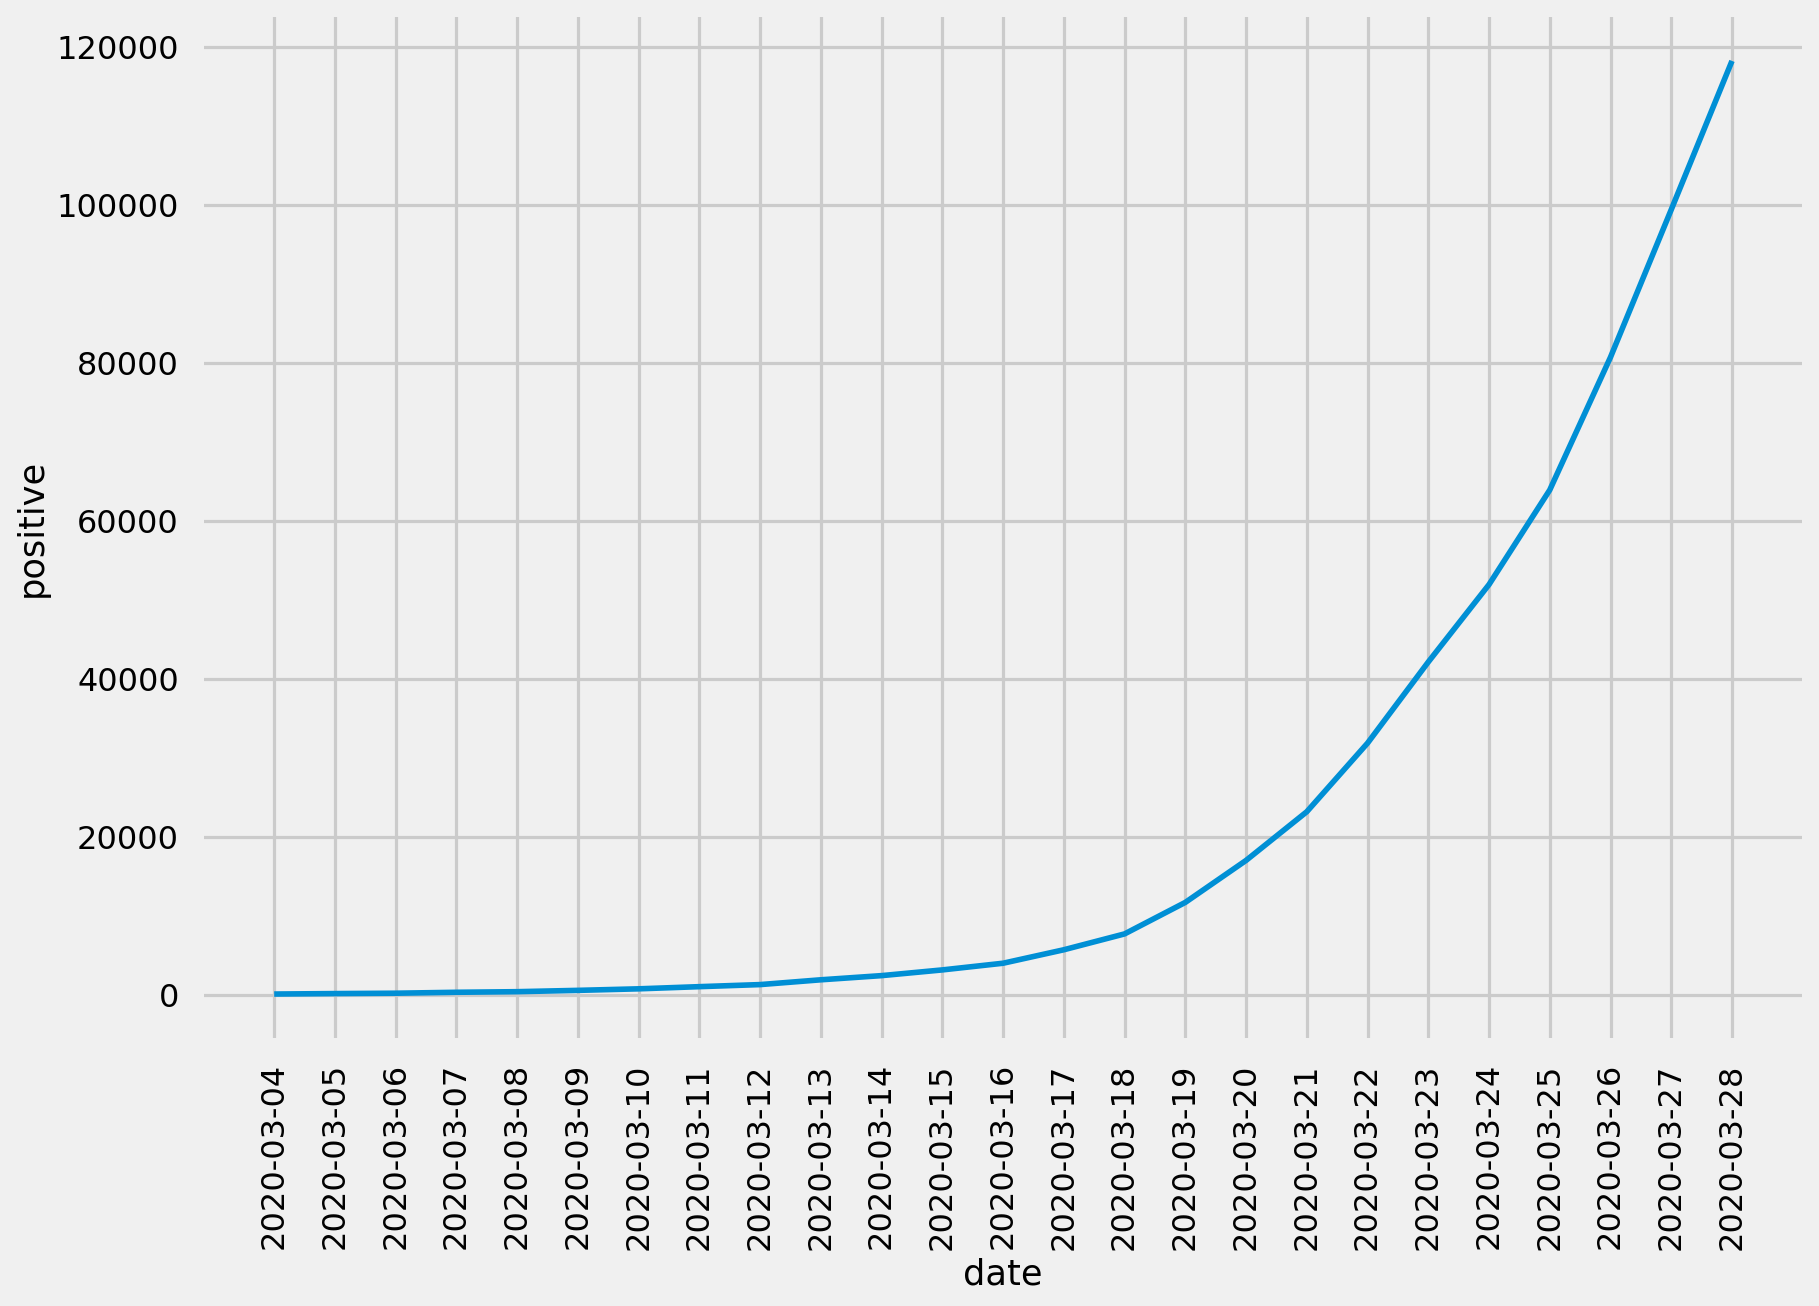

In [14]:
ax = sns.lineplot(x="date", 
                  y="positive", 
                  data=df_us)
ax.set(xticks=df_us.date.values)
plt.xticks(rotation=90)
plt.show()

# California Positive Cases

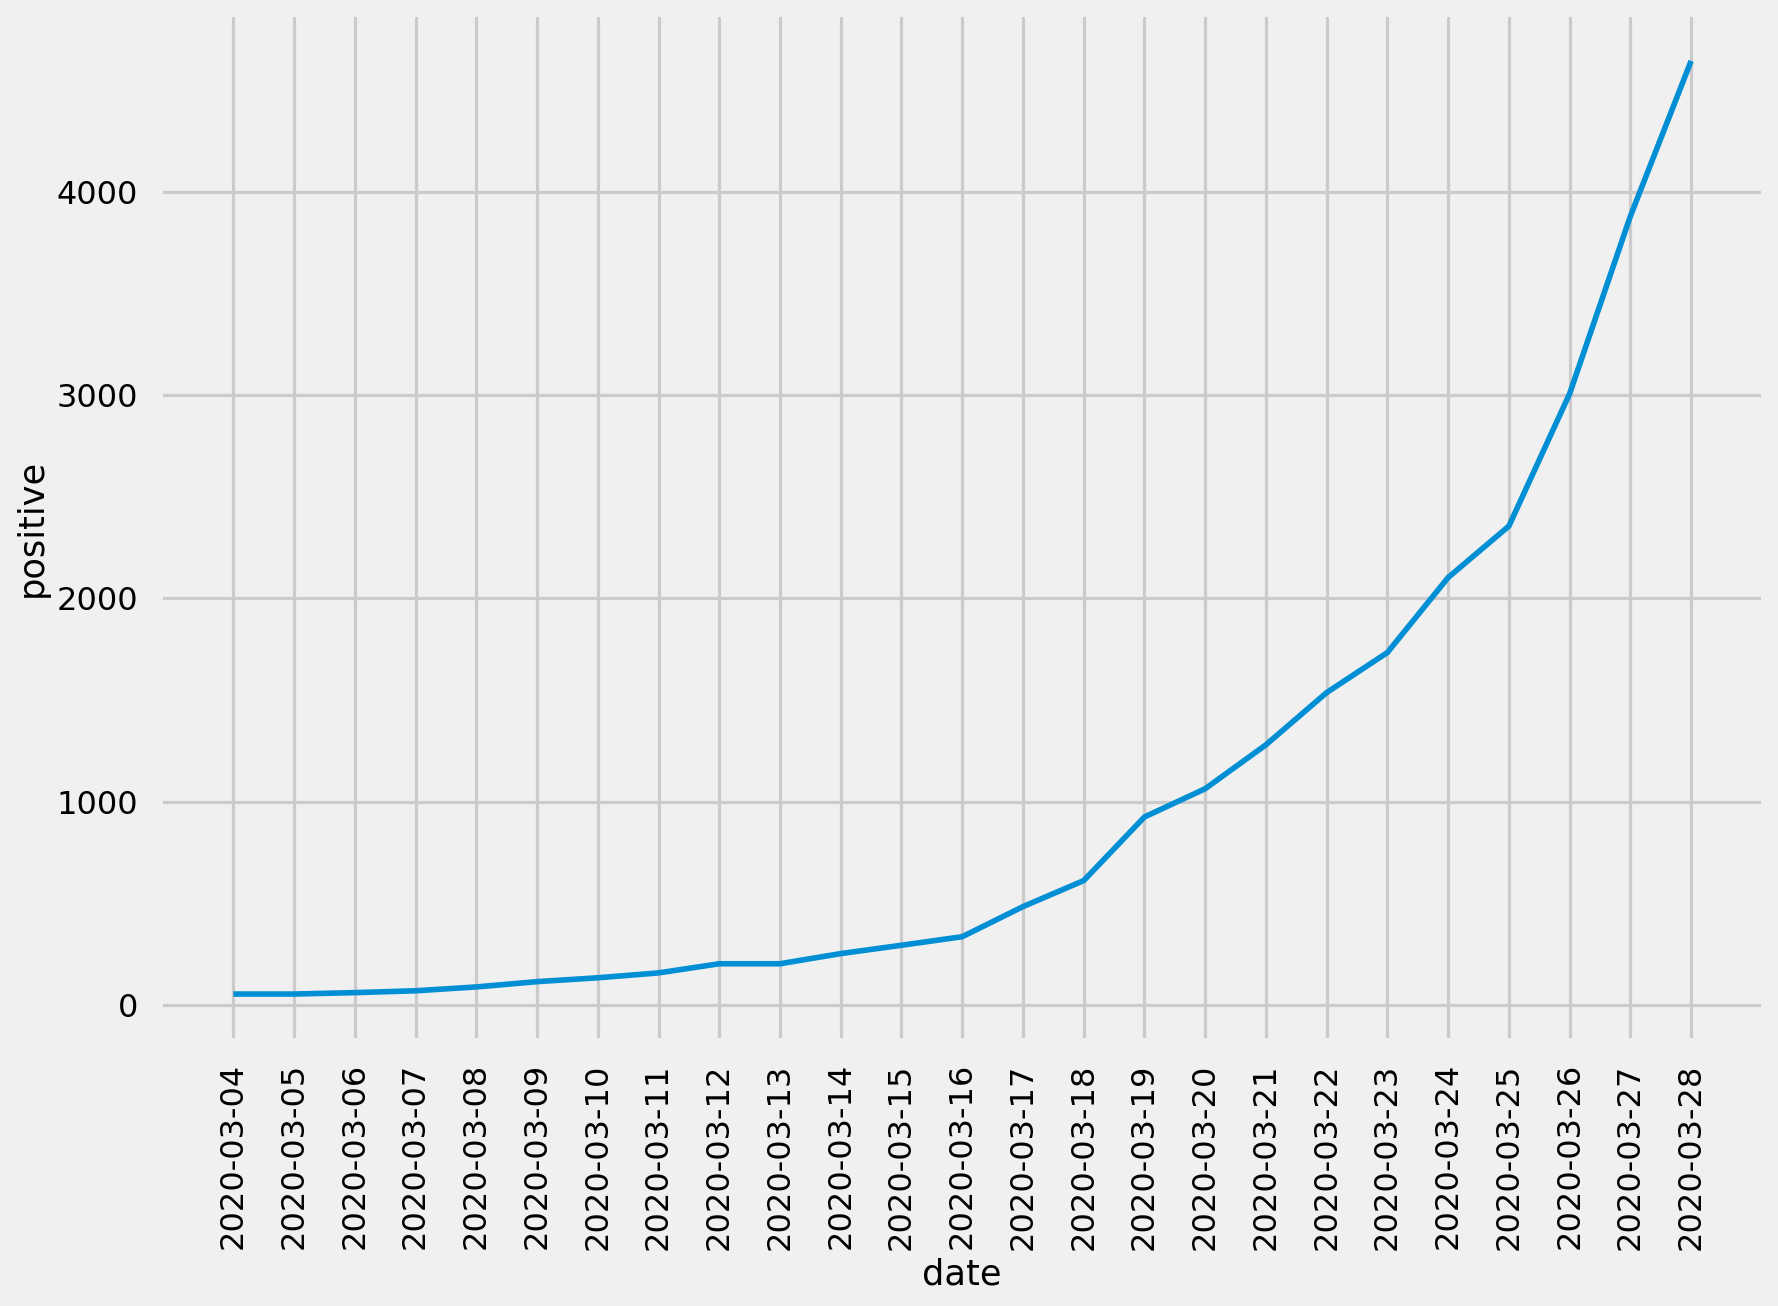

In [15]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "CA"'))
ax.set(xticks=df_states.query('state == "CA"').date.values)
plt.xticks(rotation=90)
plt.show()

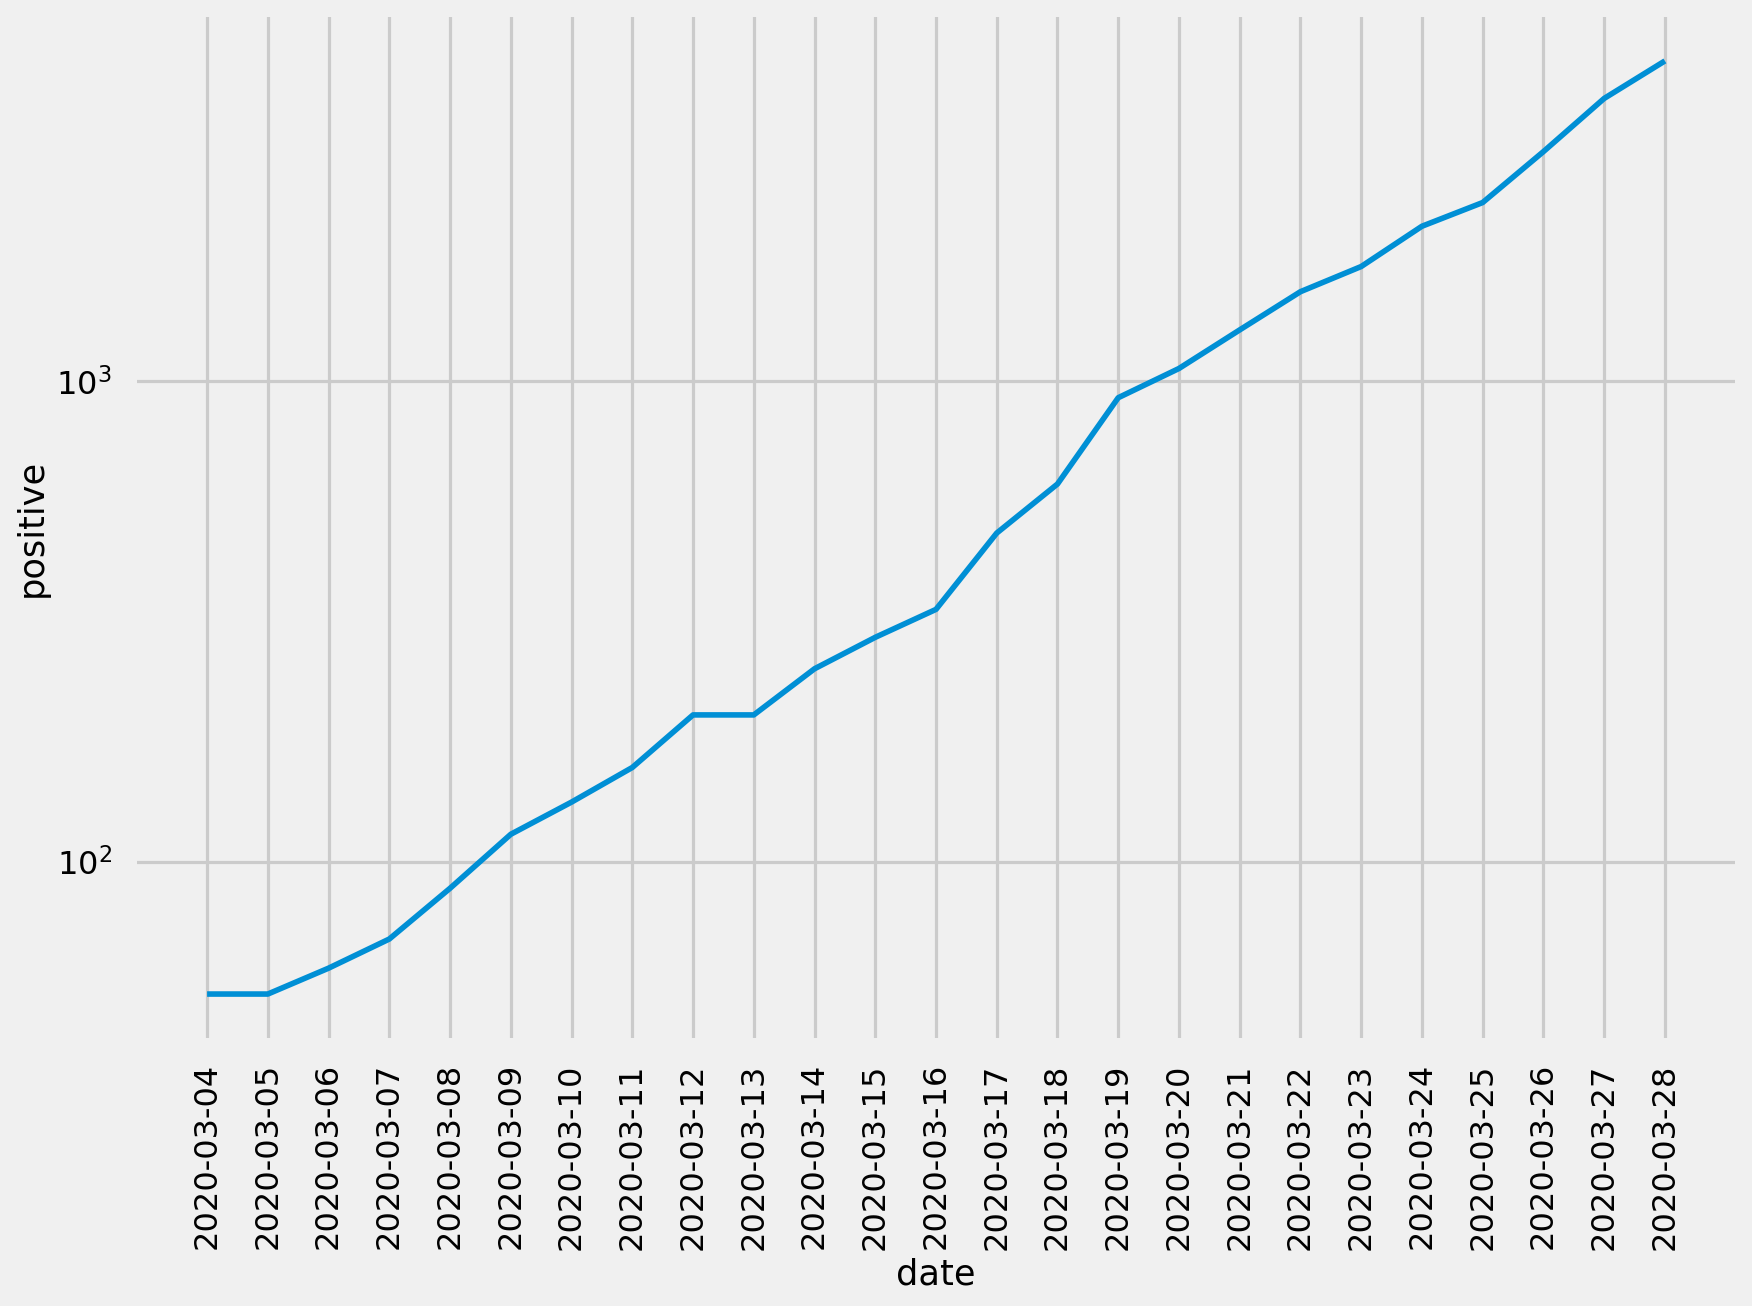

In [16]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "CA"'))
ax.set(xticks=df_states.query('state == "CA"').date.values)
plt.xticks(rotation=90)
ax.set_yscale('log')
plt.show()

## Positive and Total Tests

## California

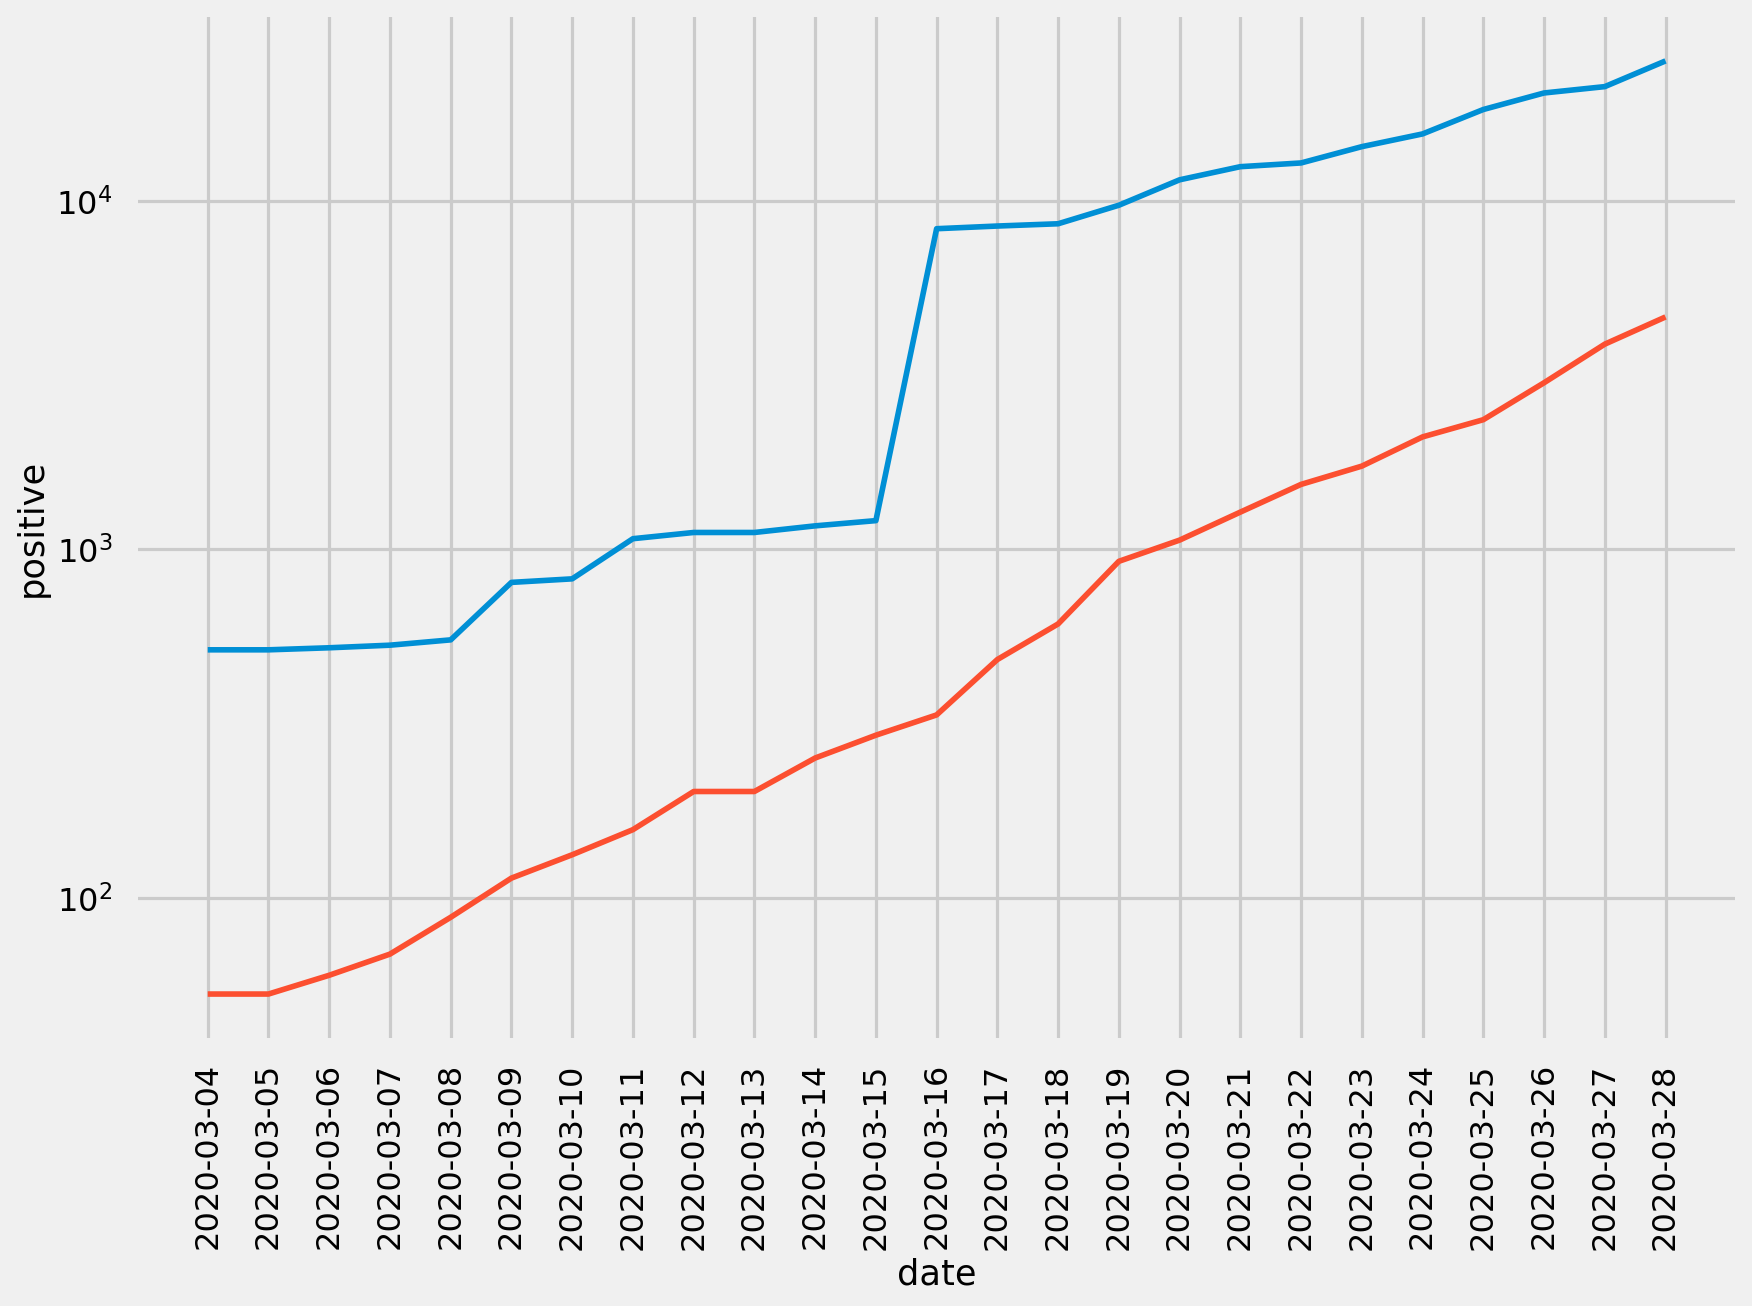

In [17]:
ax = sns.lineplot(x="date", y="total", 
                  data=df_states.query('state == "CA"'))
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "CA"'))
ax.set(xticks=df_states.query('state == "CA"').date.values)
plt.xticks(rotation=90)
ax.set_yscale('log')
plt.show()

## New York

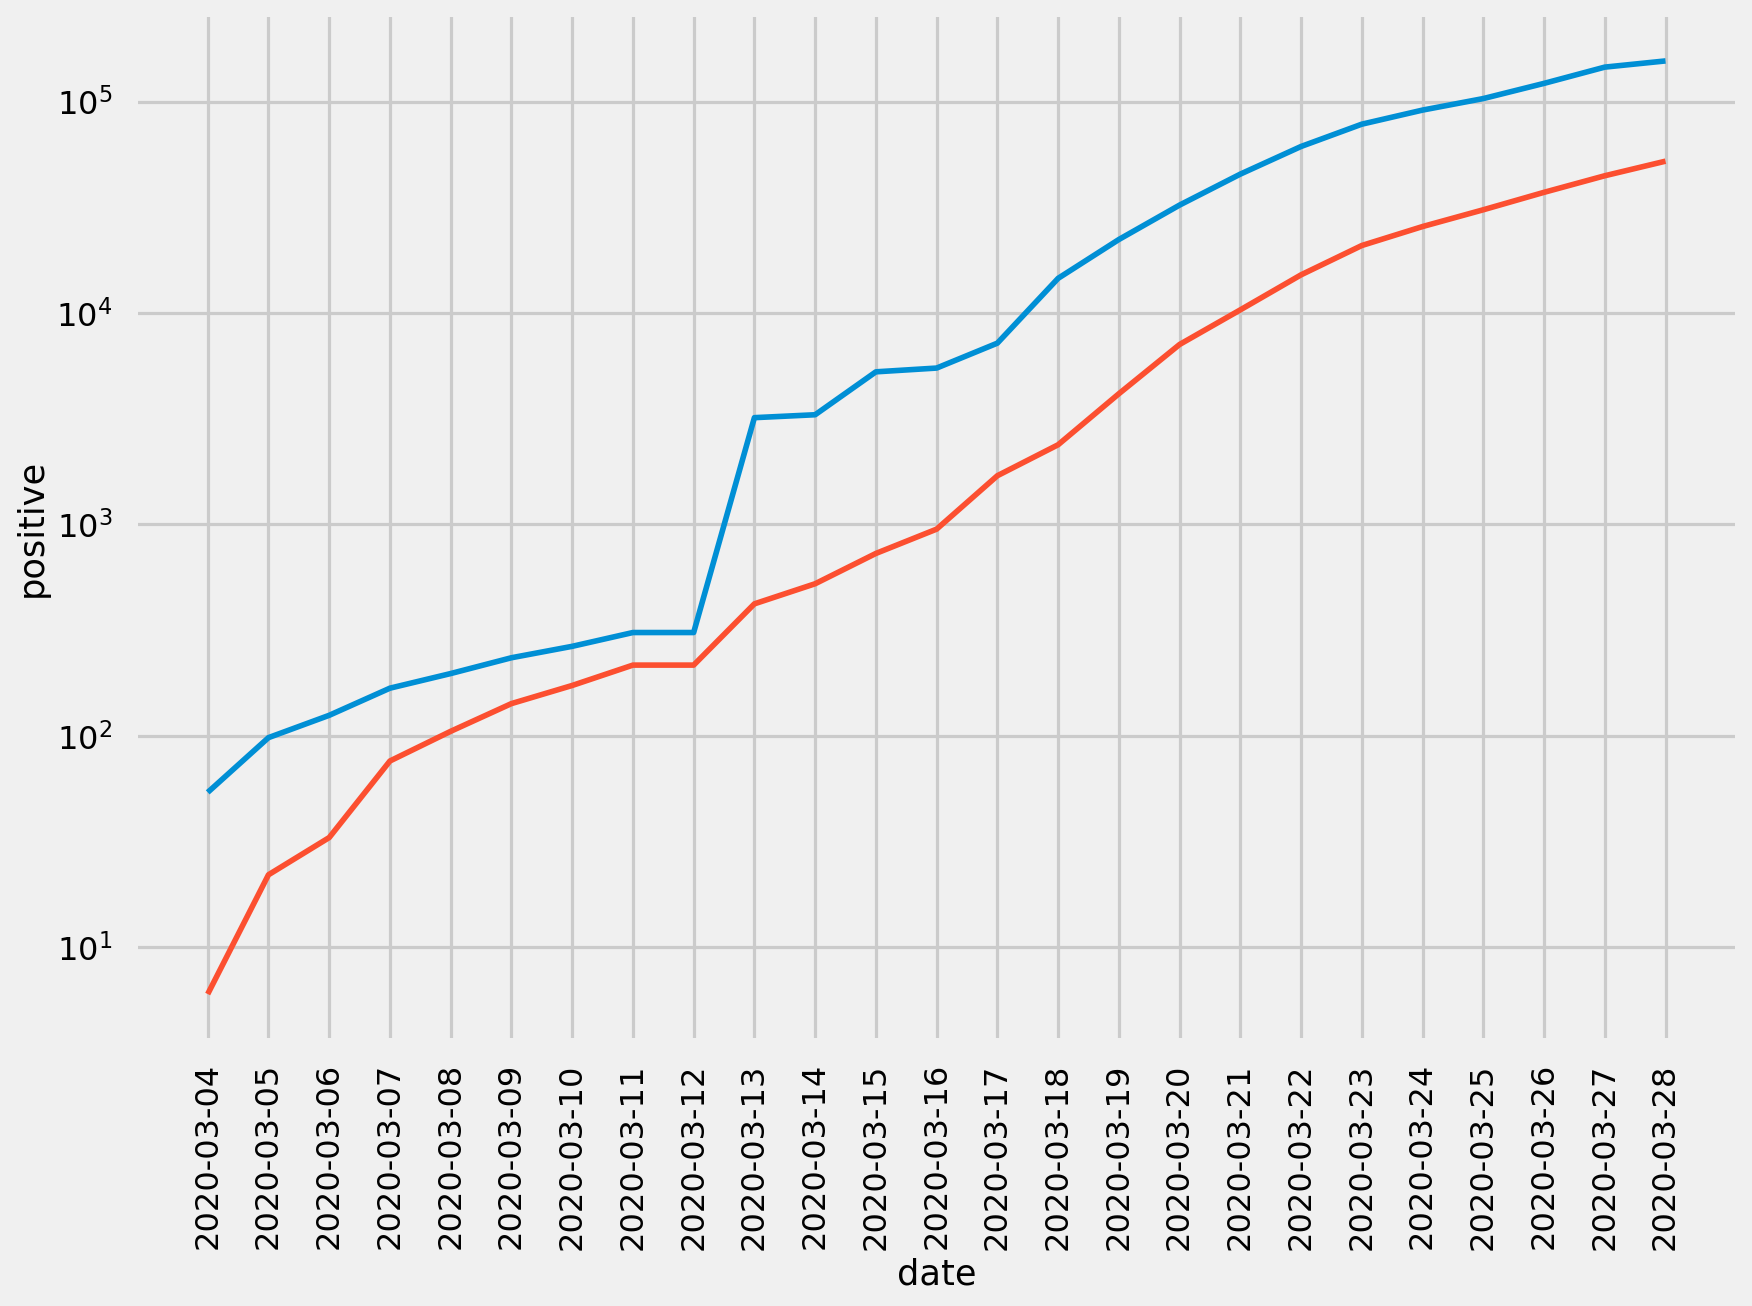

In [18]:
ax = sns.lineplot(x="date", y="total", 
                  data=df_states.query('state == "NY"'))
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "NY"'))
ax.set(xticks=df_states.query('state == "NY"').date.values)
plt.xticks(rotation=90)
ax.set_yscale('log')
plt.show()

# Top 10 States

In [19]:
latest_date = df_states['date'].max()
top_states = df_states.query('date == @latest_date').sort_values(by='positive', 
                                                    ascending=False).state.head(10).tolist()
df_top_states = df_states.query('state == @top_states')
top_states

['NY', 'NJ', 'CA', 'MA', 'FL', 'WA', 'MI', 'IL', 'LA', 'PA']

In [20]:
df_states.query('date == @latest_date').sort_values(by='positive', ascending=False)[['state', 'positive']]

,state,positive
795,NY,52318.0
724,NJ,11124.0
93,CA,4643.0
444,MA,4257.0
211,FL,3763.0
1114,WA,3723.0
515,MI,3657.0
328,IL,3491.0
422,LA,3315.0
891,PA,2751.0


# Top State Positive Cases (Log Scale)

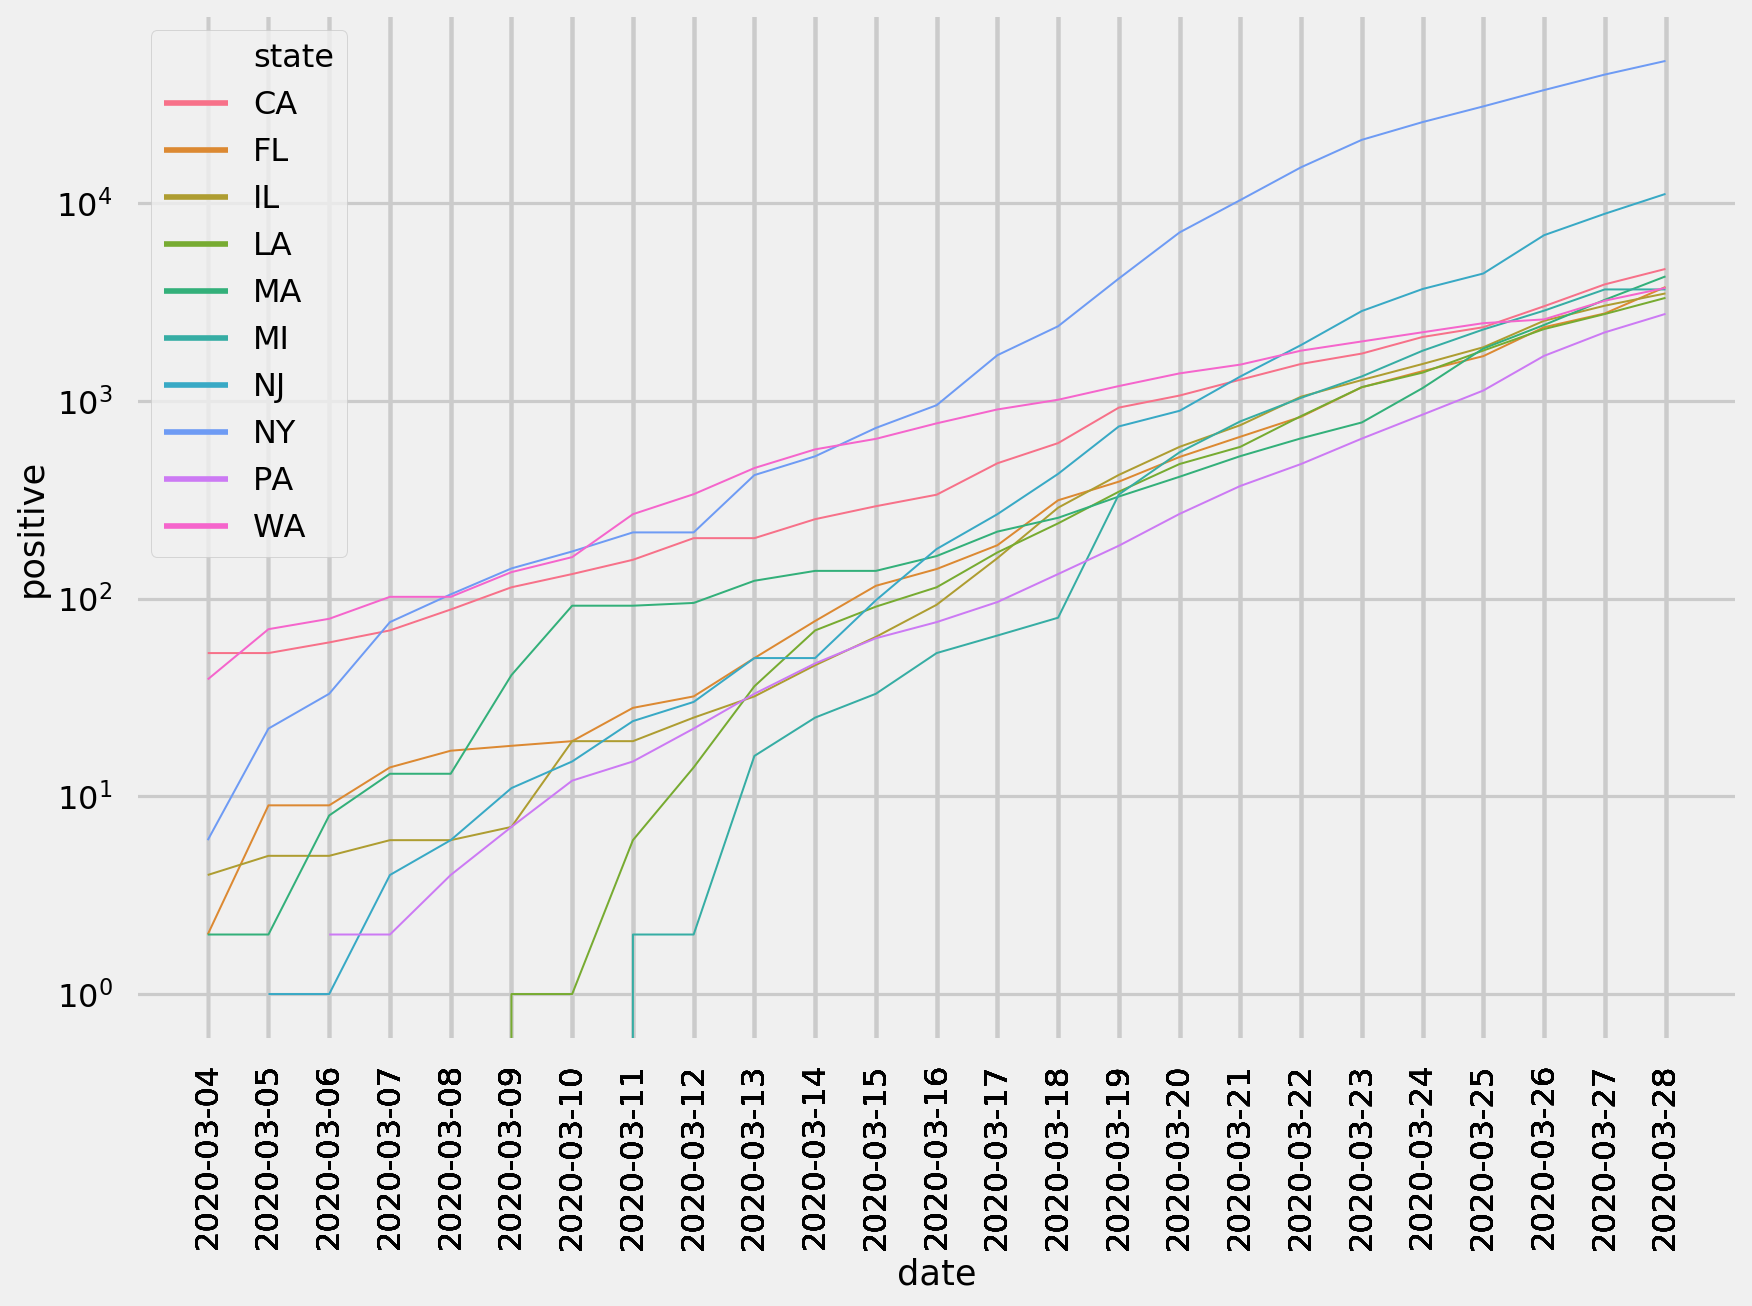

In [21]:
ax = sns.lineplot(x="date", y="positive", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Top State Positive Cases as Percent of Population (Log Scale)

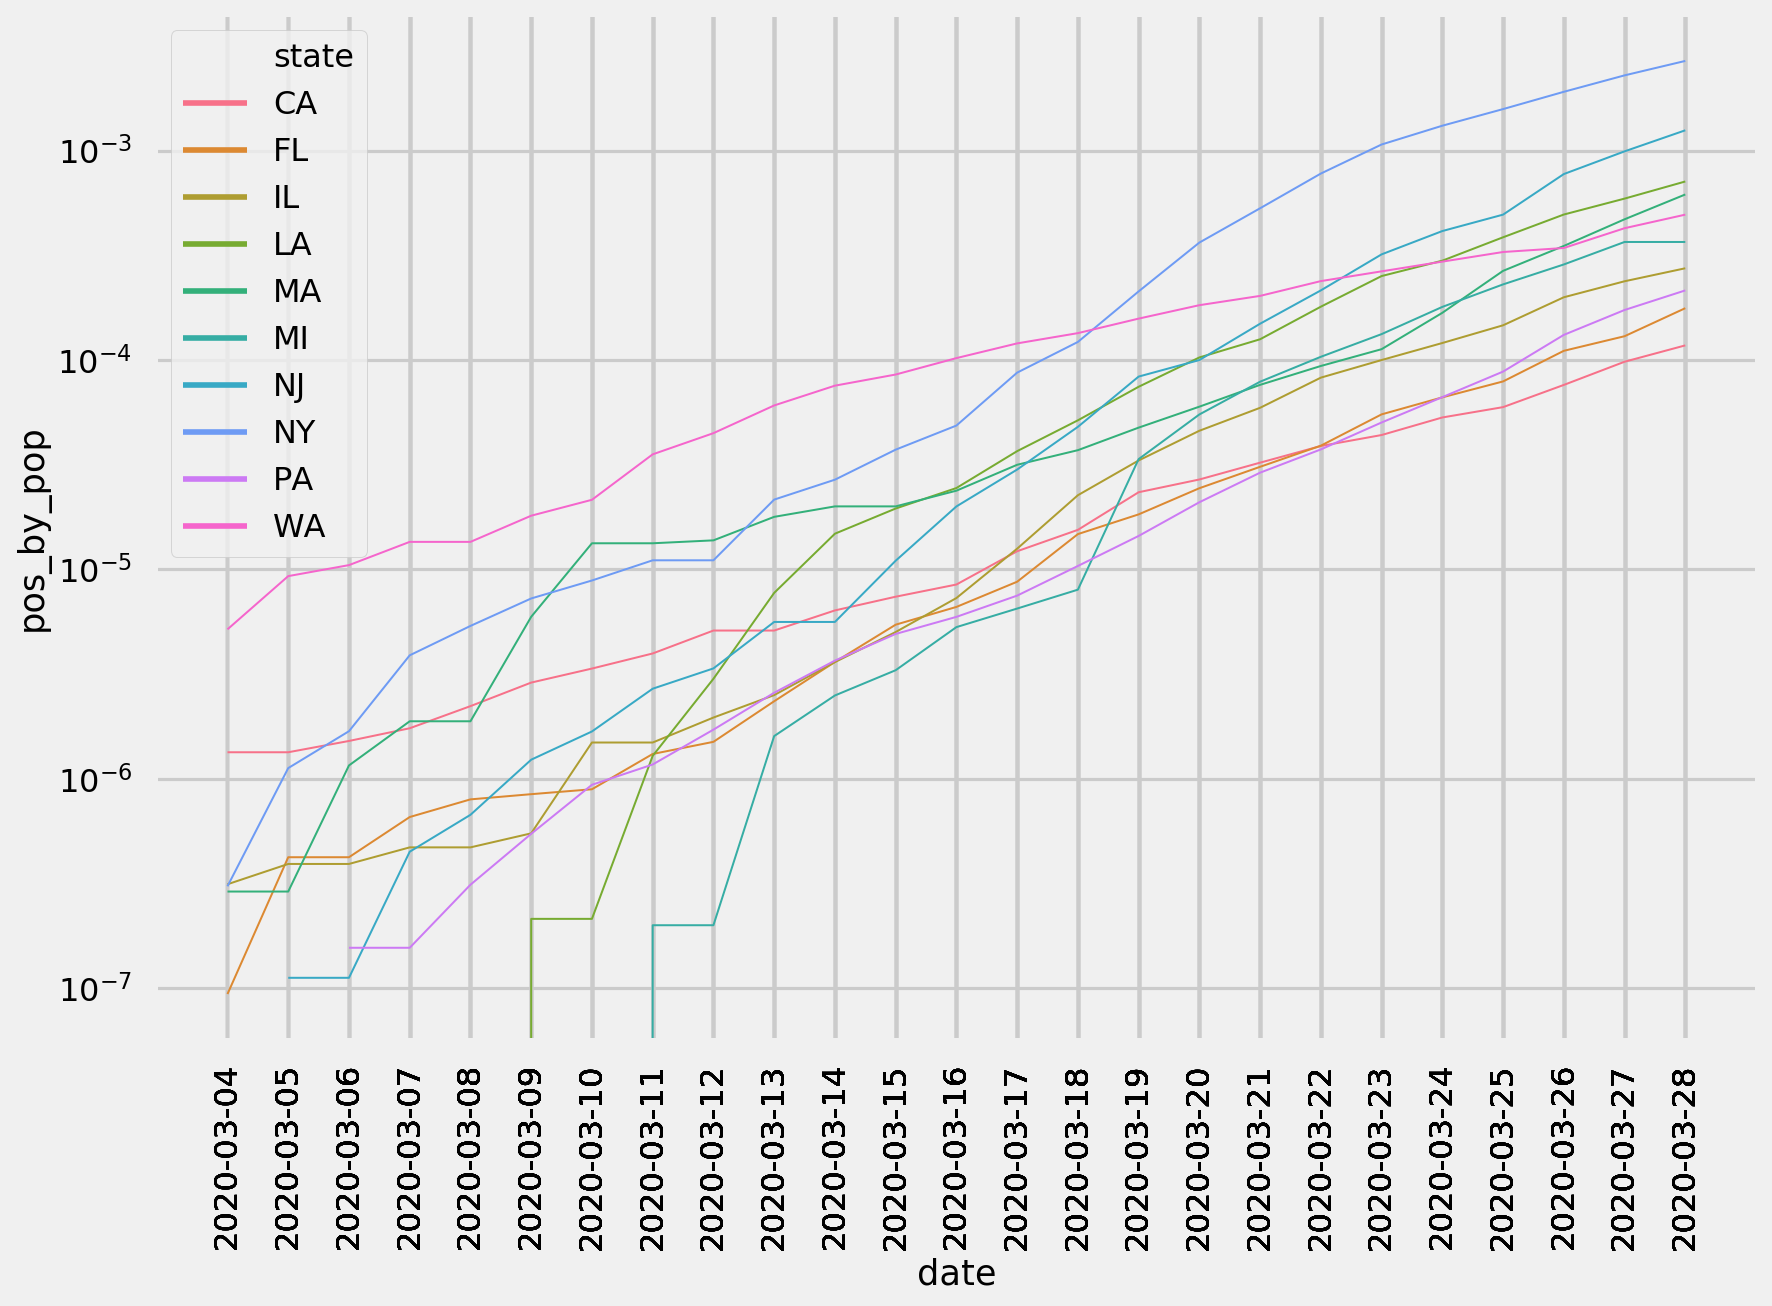

In [22]:
ax = sns.lineplot(x="date", y="pos_by_pop", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Percentage of Population Tested

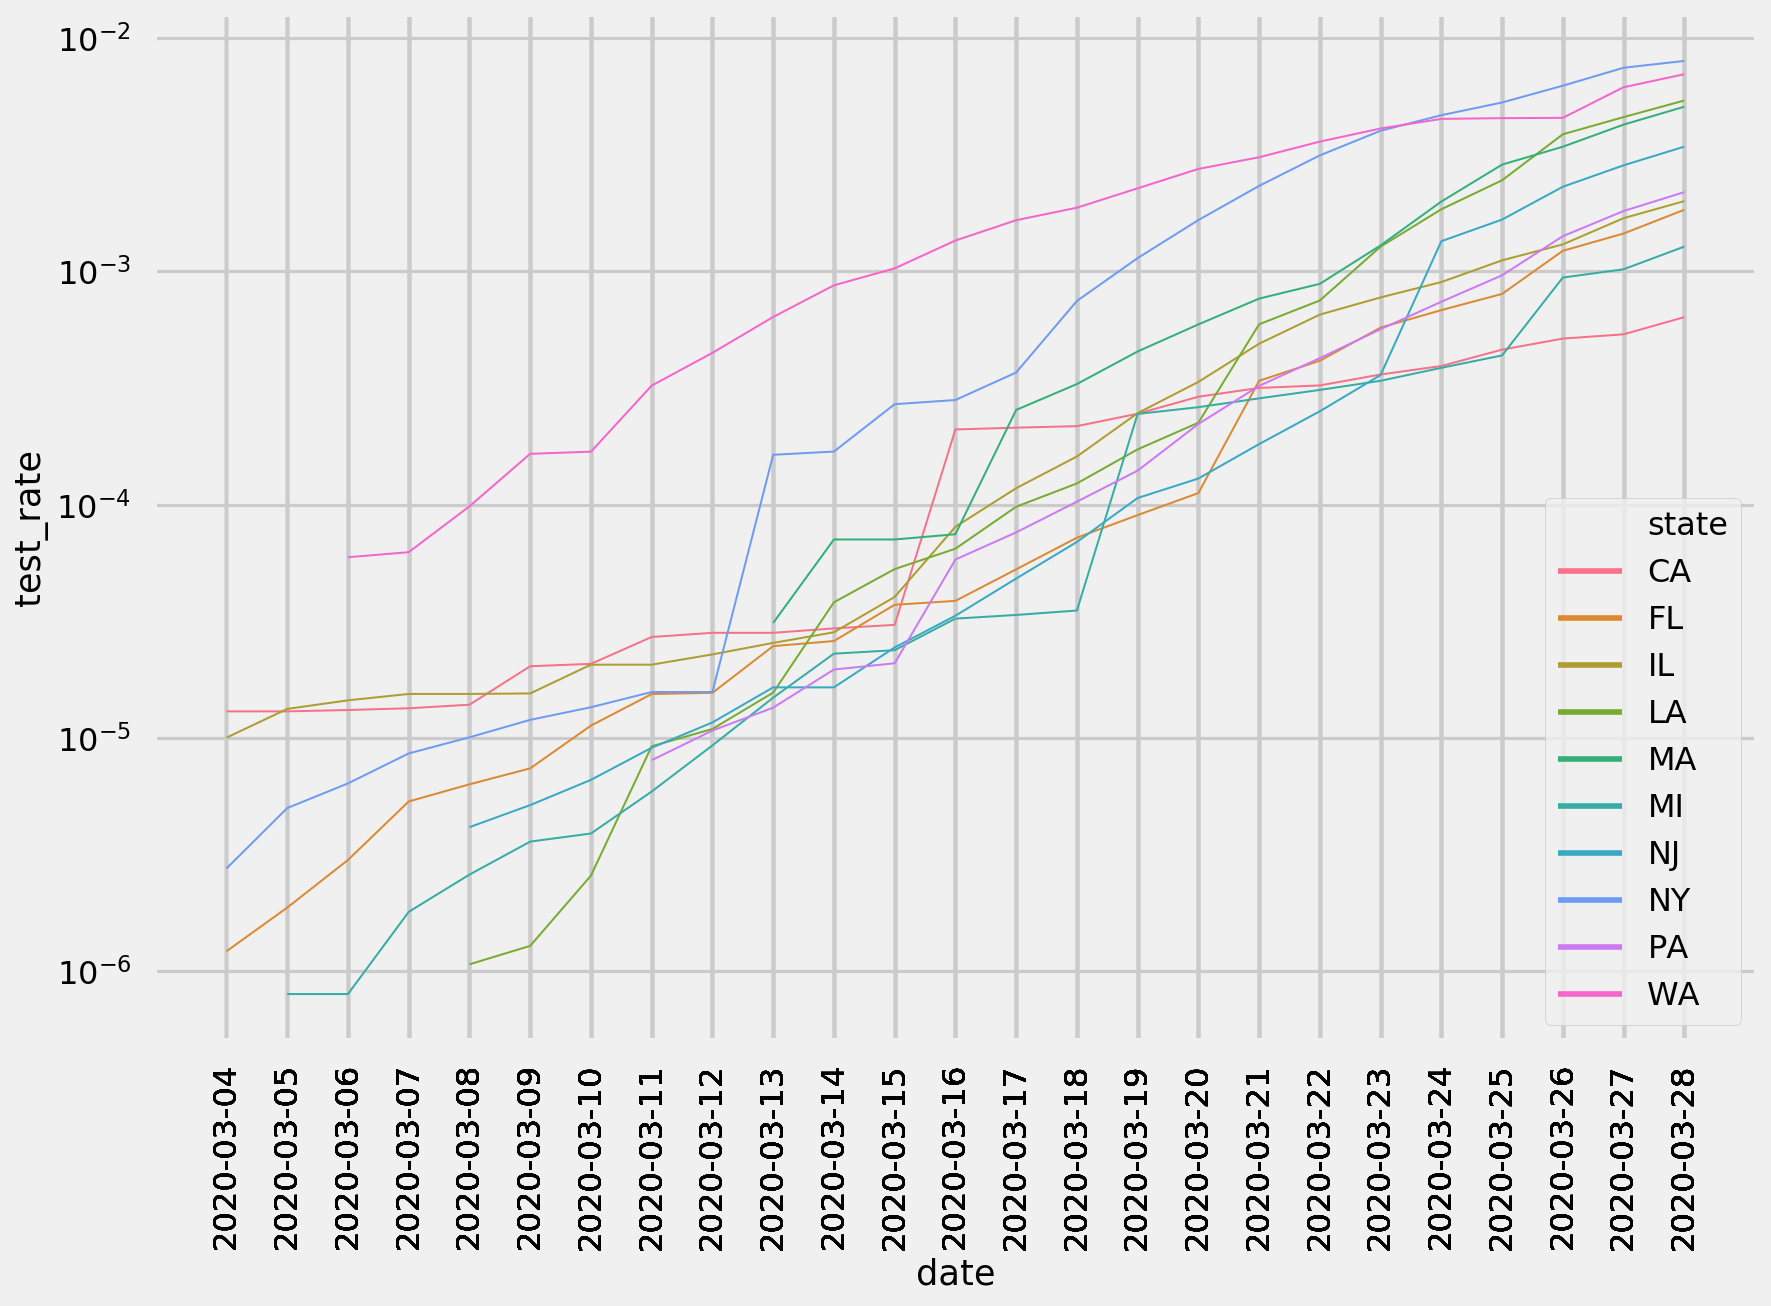

In [23]:
ax = sns.lineplot(x="date", y="test_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()